In [5]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("vittoriohaardt/rolex-on-chrono24")
print(f'Dataset path: {path}')

Dataset path: /home/ismukhin/.cache/kagglehub/datasets/vittoriohaardt/rolex-on-chrono24/versions/1


In [6]:
data = pd.read_csv(f'{path}/rolex_scaper_clean.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87117 entries, 0 to 87116
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     87117 non-null  object 
 1   reference number          84265 non-null  object 
 2   price                     81725 non-null  float64
 3   aditional shipping price  87117 non-null  float64
 4   ad name                   87035 non-null  object 
 5   movement                  83896 non-null  object 
 6   case material             82267 non-null  object 
 7   case diameter             83112 non-null  object 
 8   year of production        63398 non-null  float64
 9   condition                 85882 non-null  object 
 10  scope of delivery         87117 non-null  object 
 11  location                  87117 non-null  object 
dtypes: float64(3), object(9)
memory usage: 8.0+ MB


In [8]:
data.head()

,model,reference number,price,aditional shipping price,ad name,movement,case material,case diameter,year of production,condition,scope of delivery,location
0,Rolex Lady-Datejust,179161,9080.0,140.0,Steel Rose Gold Black Roman Dial Ladies Watch ...,Automatic,Steel,26 mm,2014.0,Very good,"Original box, original papers","United States of America, Georgia"
1,Rolex Chronograph,2917,16202.0,216.0,REF. 2917,Manual winding,Steel,33 mm,1934.0,Very good,"Original box, no original papers","Italy, Roma"
2,Rolex Daytona,116519G,41567.0,0.0,保証書付き ROLEX ロレックス デイトナ コスモグラフ K18WG 8Pダイヤ ランダム...,Automatic,White gold,39 mm,NaN,Fair,"Original papers, no original box","Japan, Nagoya City"
3,Rolex Submariner Date,116613,19795.0,235.0,New Submariner 116613 Yellow Steel Gold Cerami...,Automatic,Steel,40 mm,2020.0,Unworn,"Original box, original papers","United States of America, Florida, Miami"
4,Rolex Submariner Date,16610,10674.0,145.0,1990s ROLEX SUBMARINER 16610 Tritium vintage G...,Automatic,NaN,40 mm,1990.0,Good,"Original box, original papers","Japan, Ehime yawatahama"


# Постановка задачи

Имеется датасет с информацией о стоимости часов марки `Rolex`. Набор данных имеет следующие столбцы:
1. Модель (`model`)
2. Уникальный каталожный номер (`reference number`)
3. Цена (`price`)
4. Цена доставки (`aditional shipping price`)
5. Название объявления (`ad name`)
6. Часовой механизм (`movement`)
7. Метариал кейса (`case material`)
8. Диаметр кейса (`case diameter`)
9. Год производства (`year of production`)
10. Состояние (`condition`)
11. Состав комплекта (`scope of delivery`)
12. Локация производства (`location`).

Необходимо предсказать итоговую стоимость часов в зависимости от параметров, иными словами есть множество объектов-признаков $X = \{x^{(i)} = (x^{(i)}_1, x^{(i)}_2,...,x^{(i)}_{11}) | i = \overline{1,N} \}$ и множество меток $Y = \{y^{(i)}\ | i = \overline{1,N} \}$. Таким образом, можно сформировать множество пар вида: $\{(x^{(i)}, y^{(i)})| i = \overline{1,N} \}$. Задача заключается в нахождении некоторой аппроксимации $f: X \rightarrow Y$, которая по новым объектам $x \in X$ предсказывает $y \in Y$, т.е $y = f(x)$. В рамках нашего набора данных столбец 3 $-$ метка, которую планируем предсказывать, а остальные столбцы $-$ объекты-признаки.

# Первичная обработка данных

## Визуализация

Построим точечные графики для цены от различных объектов-признаков, при этом уберем явные текстовые признаки

/home/ismukhin/miniconda3/envs/ml-course-env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/ismukhin/miniconda3/envs/ml-course-env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/ismukhin/miniconda3/envs/ml-course-env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21547 (\N{CJK UNIFIED IDEOGRAPH-542B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/ismukhin/miniconda3/envs/ml-course-env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12416 (\N{HIRAGANA LETTER MU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/ismukhin/miniconda3/envs/ml-course-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) 

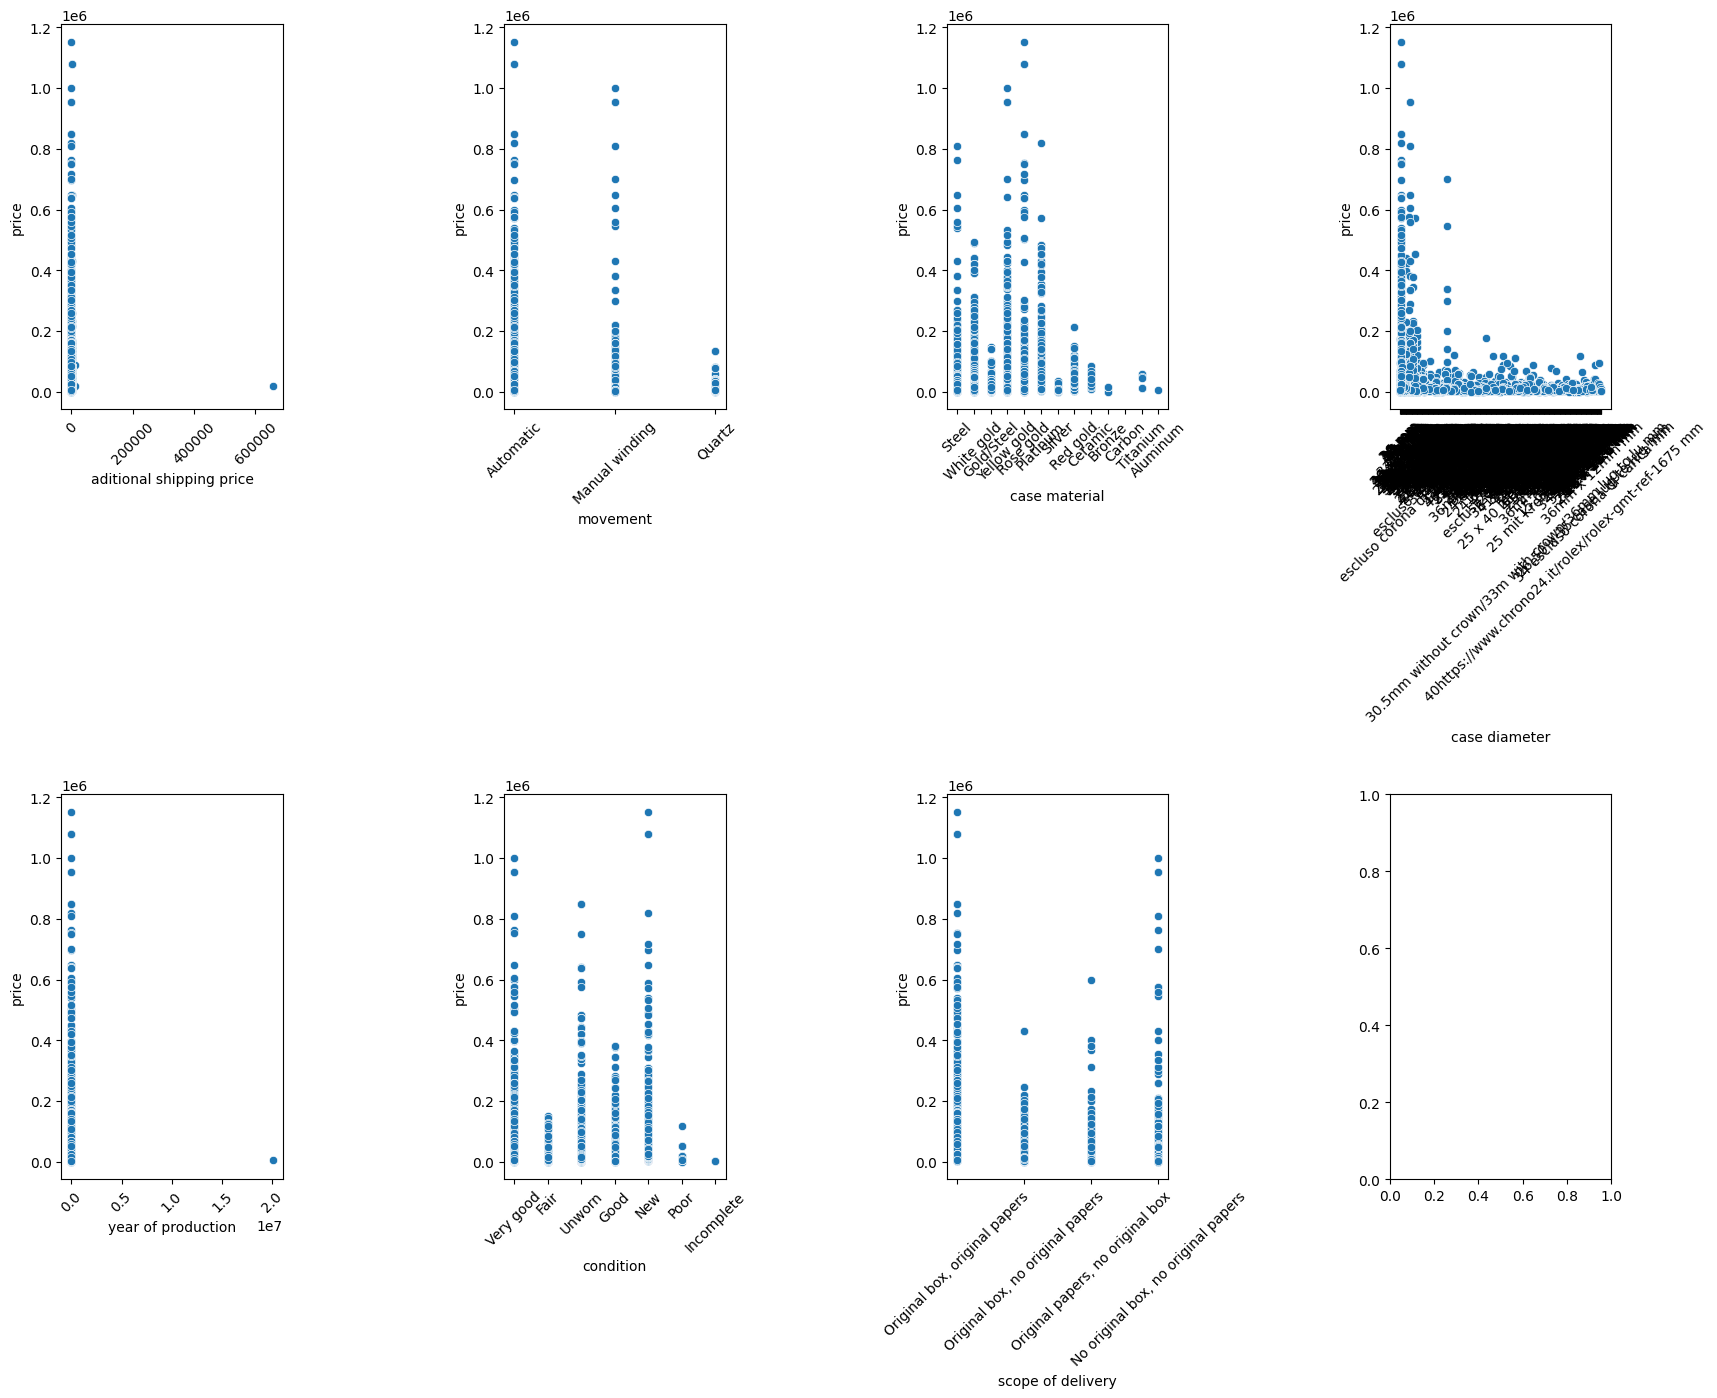

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
plt.subplots_adjust(wspace=1, hspace=1)
axes_flat = axes.flatten()

columns = data.columns.drop(['price', 'reference number', 'model', 'ad name', 'location'])
for i, column in enumerate(columns):
    ax = axes_flat[i]
    ax.tick_params(axis='x', rotation=45)
    sb.scatterplot(data=data, x=column, y='price', ax=ax)
#columns